In [54]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm
import seaborn as sns

In [55]:
# keep only columns that are related to mutations
immune_df = pd.read_excel("gene/data/tcga-immune.xlsx")
immune_df["TCGA Study"] = immune_df["TCGA Study"].replace(["COAD", "READ"], "COADREAD")

In [56]:
selected_feats = [
"mit_wsi_count",
"HSC",
"mean(ND)",
"mit_nodeDegrees_max",
"mit_nodeDegrees_std",
"mean(CL)",
"mit_clusterCoff_std",
"mit_clusterCoff_perc10",
"mit_clusterCoff_perc80",
"mit_cenDegree_mean",
"mit_cenDegree_std",
"mit_cenCloseness_max",
"mit_cenEigen_mean",
"mit_cenEigen_max",
"mit_cenEigen_std",
"mean(HC)",
"mit_cenHarmonic_std",
]
mitosis_feats = pd.read_csv('D:/tcga/tcga_mitosis_ClusterByCancer.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type", "temperature"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type", "temperature"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")

In [57]:
cancer_type = "BRCA"
mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
gene_exp_cancer = immune_df[immune_df["TCGA Study"]==cancer_type]


# drop missing mutations
gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")
# drop cases with all mutations as Nan


# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['TCGA Participant Barcode']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_exp_cancer[gene_exp_cancer['TCGA Participant Barcode'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='TCGA Participant Barcode')

## Sort the dataframes based on 'case_name'
df1_common = df1_common.sort_values('bcr_patient_barcode')
df2_common = df2_common.sort_values('TCGA Participant Barcode')

df1_common = df1_common.reset_index(drop=True)
df2_common = df2_common.reset_index(drop=True)

# X = df1_common.drop(columns=["bcr_patient_barcode", "type"]).reset_index(drop=True)
# Y = df2_common.drop(columns=['case_id', 'type', 'slide_id']).reset_index(drop=True)



p-value annotation legend:
      ns: 1.00e-02 < p <= 1.00e+00
       *: 1.00e-03 < p <= 1.00e-02
      **: 1.00e-04 < p <= 1.00e-03
     ***: 1.00e-05 < p <= 1.00e-04
    ****: p <= 1.00e-05

C1 vs. C2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.906e-02 U_stat=2.140e+06
C3 vs. C6: Mann-Whitney-Wilcoxon test two-sided, P_val:7.587e-01 U_stat=1.001e+05


(<Axes: xlabel='Immune Subtype', ylabel='mean(DC)'>,
  <statannotations.Annotation.Annotation at 0x2b58ba10790>])

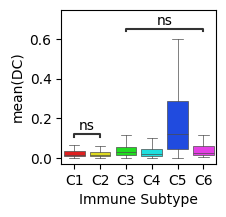

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import itertools
from statannotations.Annotator import Annotator

subtype_sorted = df2_common.sort_values(by="Immune Subtype")["Immune Subtype"]
subtype_sorted = subtype_sorted.dropna(axis=0, how="any")
mosi = pd.concat([df1_common[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)", "max(ND)"]], df2_common["Immune Subtype"]], axis=1)
mosi = mosi.iloc[subtype_sorted.index]

# Define the custom colors for each immune subtype
colors = {
    'C1': '#FF0000',
    'C2': '#FFFA00',
    'C3': '#00FD00',
    'C4': '#00FFFF',
    'C5': '#0039FF',
    'C6': '#FF25FF',
}

# Create the boxplot
plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=mosi, x="Immune Subtype", y="mean(DC)", palette=colors, showfliers=False, linewidth=0.5)
# ax.set_ylim(-1, 30)
# ax.set_xlim(-.6, 5.6)

# Calculate the IQR
# Q1 = mosi["mean(DC)"].quantile(0.25)
# Q3 = mosi["mean(DC)"].quantile(0.75)
# IQR = Q3 - Q1
# mid = mosi["mean(DC)"].median()

# # Define the whiskers
# lower_whisker = Q1 - 1.5 * IQR
# upper_whisker = Q3 + 1.5 * IQR

# # Set the y-axis limits based on the boxplot whiskers
# ax.set_ylim(mid + lower_whisker*1.1 , (mid + upper_whisker)*1.1)

# Perform pairwise statistical tests
subtypes = mosi['Immune Subtype'].unique()
pairs = list(itertools.combinations(subtypes, 2))
significant_pairs = []


for (subtype1, subtype2) in pairs:
    data1 = mosi[mosi['Immune Subtype'] == subtype1]['mean(DC)']
    data2 = mosi[mosi['Immune Subtype'] == subtype2]['mean(DC)']
    stat, p_value = mannwhitneyu(data1, data2)
    if p_value > 0.01:
        significant_pairs.append((subtype1, subtype2))

annotator = Annotator(ax, significant_pairs, data=mosi, x="Immune Subtype", y="mean(DC)")
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=False, verbose=2)
annotator.apply_and_annotate()



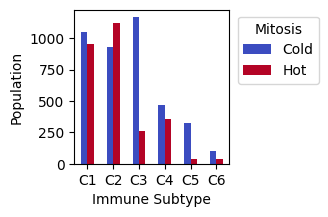

In [31]:
mosi = pd.concat([df1_common["temperature"], df2_common["Immune Subtype"]], axis=1)
mosi = mosi.dropna(axis=0, how="any")
mosi = mosi.rename(columns={"temperature": "Mitotic Temperature"})
# Group by 'Immune Subtype' and 'cluster_2', then count occurrences
grouped = mosi.groupby(['Immune Subtype', 'Mitotic Temperature']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(2, 2))
grouped.plot(kind='bar', ax=ax, cmap="coolwarm")
ax.set_xlabel('Immune Subtype')
ax.set_ylabel('Population')
plt.legend(title="Mitosis", bbox_to_anchor=(1.01, 1), loc='upper left')
# ax.set_title('Population of Each Immune Subtype for Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu, ks_2samp
import itertools
from statannotations.Annotator import Annotator



# Prepare the data
immune_feats = ["Stromal Fraction", "Intratumor Heterogeneity", "Proliferation",
                "SNV Neoantigens", "Indel Neoantigens", "Nonsilent Mutation Rate",
                 "Number of Segments", "Fraction Altered", "Aneuploidy Score",
                 "Homologous Recombination Defects", "CTA Score",
                 # immune features
                 "Leukocyte Fraction", "TIL Regional Fraction", "Wound Healing", "Macrophage Regulation",
                 "Lymphocyte Infiltration Signature Score", "IFN-gamma Response", "TGF-beta Response",
                 "BCR Evenness", "TCR Evenness", "Th1 Cells", "Th2 Cells", "Th17 Cells"]
for immune_feat in immune_feats:
    mosi = pd.concat([df1_common["temperature"], df2_common[immune_feat]], axis=1)
    mosi = mosi.dropna(axis=0, how="any")
    mosi = mosi.rename(columns={"temperature": "Mitotic Temperature"})
    mosi = mosi.sort_values(by="Mitotic Temperature")

    #standardize the values
    if immune_feat in ["SNV Neoantigens", "Indel Neoantigens", "Nonsilent Mutation Rate", "Number of Segments"]:
        mosi[immune_feat] = mosi[immune_feat].apply(lambda x: np.log10(x + 1))
        mosi = mosi.rename(columns={immune_feat: f"-log10({immune_feat}+1)"})
        immune_feat = f"-log10({immune_feat}+1)"

    # Unique temperature states
    temperature_states = mosi['Mitotic Temperature'].unique()

    # Create the boxplot using matplotlib
    plt.figure(figsize=(1.8,3))
    ax = plt.gca()

    # Boxplot
    # Get the colors from the 'copper' palette
    palette = sns.color_palette('coolwarm', n_colors=100)
    # Set the alpha value
    alpha = 0.1
    # Modify the colors to include alpha
    colors = [(r, g, b, alpha) for r, g, b in palette]
    # Assign the first and last colors from the palette
    colors = [colors[0], colors[-1]]
    sns.boxplot(data=mosi, x='Mitotic Temperature', y=immune_feat, ax=ax, color=(1, 1, 1, 0.3), fliersize=0, linewidth=0.5, whis=0)
    sns.violinplot(data=mosi, x='Mitotic Temperature', y=immune_feat, ax=ax, palette=colors, fliersize=0, linewidth=0.5, alpha=0.5)


    # Perform pairwise statistical tests and add annotations
    pairs = list(itertools.combinations(temperature_states, 2))
    y_max = mosi[immune_feat].max()


    # # Perform pairwise statistical tests
    annotator = Annotator(ax, pairs, data=mosi, x='Mitotic Temperature', y=immune_feat, plot="violinplot")
    p_val_fmt = None # [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', pvalue_format=p_val_fmt, hide_non_significant=False, verbose=2, alpha=0.01,
                        show_test_name=False)
    annotator.apply_and_annotate()

    # for (temp1, temp2) in pairs:
    #     data1 = mosi[mosi['Mitotic Temperature'] == temp1][immune_feat]
    #     data2 = mosi[mosi['Mitotic Temperature'] == temp2][immune_feat]
    #     # stat, p_value = mannwhitneyu(data1, data2, alternative="two-sided", method="exact")
    #     # Group data by CNV levels
    #     groups = mosi.groupby('Mitotic Temperature')[immune_feat].apply(list)
    #     # Perform one-way ANOVA
    #     f_statistic, p_value = stats.f_oneway(*groups)

    #     # Calculate position for text annotation
    #     Q1_desired = data1.quantile(0.25)
    #     Q3_desired = data1.quantile(0.75)
    #     IQR_desired = Q3_desired - Q1_desired
    #     max_whisker_desired = min(max(data1), Q3_desired + 1.5 * IQR_desired)
    #     min_whisker_desired = max(min(data1), Q3_desired - 1.5 * IQR_desired)

    #     Q1_Others = data2.quantile(0.25)
    #     Q3_Others = data2.quantile(0.75)
    #     IQR_Others = Q3_Others - Q1_Others
    #     max_whisker_Others = min(max(data2), Q3_Others + 1.5 * IQR_Others)
    #     min_whisker_Others = max(min(data2), Q3_Others - 1.5 * IQR_Others)

    #     max_whisker = max(max_whisker_desired, max_whisker_Others) 
    #     min_whisker = min(min_whisker_desired, min_whisker_Others, -max_whisker*0.2)
    #     text_y = max_whisker * 1.03
    #     h =  max_whisker * 0.02  # height of the lines for annotations

    #     if p_value < 0.05:
    #         p_text = f"p={p_value:.02}" if p_value > 0.0001 else "p<0.0001"
    #     else:
    #         p_text = "NS"
    #     x1, x2 = temperature_states.tolist().index(temp1), temperature_states.tolist().index(temp2)
    #     y = text_y # y_max + h * (pairs.index((temp1, temp2)) + 1)
    #     # ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
    #     ax.text((x1 + x2) * 0.5, y + h, p_text, ha='center', va='bottom', color='k')
    #     ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black', lw=1.5)


    # Remove top and right box lines
    ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_title(immune_feat)
    # ax.set_ylim(None,max_whisker*1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize the plot
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.stats.multitest import multipletests

def calculate_corr_matrix(df1, df2, method='spearman', pvalue_correction="fdr_bh"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")
    
    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            df_no_na = pd.concat([df1[row], df2[col]], axis=1)
            df_no_na = df_no_na.dropna(axis=0, how="any")
            if method == 'spearman':
                corr, pvalue = stats.spearmanr(df_no_na[row], df_no_na[col])
            elif method == 'pearson':
                corr, pvalue = stats.pearsonr(df_no_na[row], df_no_na[col])
            corr_matrix.at[row, col] = np.float32(corr)
            pvalue_matrix.at[row, col] = np.float32(pvalue)
    # correcting pvalues for the number of genes
    if pvalue_correction is not None:
        # Flatten the DataFrame to a 1D array
        pvals = pvalue_matrix.values.flatten()
        # Apply the correction
        corrected_pvals = multipletests(pvals, alpha=0.05, method=pvalue_correction)[1]
        # Reshape the corrected p-values back to the original shape of pvalue_matrix
        corrected_pvals_matrix = corrected_pvals.reshape(pvalue_matrix.shape)
        # Replace the values in the original DataFrame
        pvalue_matrix.loc[:, :] = corrected_pvals_matrix

    return corr_matrix, pvalue_matrix

# immune_feats = ["Th1 Cells","Th2 Cells","Th17 Cells","BCR Evenness","TCR Evenness","B Cells Memory","B Cells Naive","Dendritic Cells Activated","Dendritic Cells Resting","Macrophages M0","Macrophages M1","Macrophages M2","Mast Cells Activated","Mast Cells Resting","Monocytes","NK Cells Activated","NK Cells Resting","Plasma Cells","T Cells CD4 Memory Activated","T Cells CD4 Memory Resting","T Cells CD4 Naive","T Cells CD8","T Cells Follicular Helper","T Cells gamma delta","T Cells Regulatory Tregs","Lymphocytes","Neutrophils","Eosinophils","Mast Cells","Dendritic Cells","Macrophages"]

# X = df1_common[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "mean(HC)", "max(EC)"]] #.drop(["bcr_patient_barcode", "type", "temperature"], axis=1)
# Y = df2_common[immune_feats]

# corr_matrix, pvalue_matrix = calculate_corr_matrix(Y, X, method='pearson', pvalue_correction="fdr_bh")

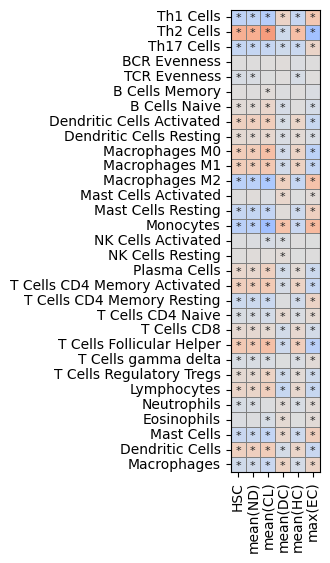

In [9]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Perform hierarchical clustering
# row_linkage = linkage(corr_matrix, method='ward')
col_linkage = linkage(corr_matrix.T, method='ward')

# Get the order of rows and columns based on clustering
# row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the data matrix
corr_matrix_reordered = corr_matrix.iloc[:, col_order]#.iloc[row_order, :]
pval_matrix_reordered = pvalue_matrix.iloc[:, col_order]#.iloc[row_order, :]


# Plot the heatmap with reordered data and customization
fig, ax = plt.subplots(1, 1, figsize=(1.2, 6))
annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '') #  
heatmap = sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                    linewidths=0.5, linecolor='gray', square=True,
                    annot=annotations, fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                    cbar_kws={'shrink': 0.5, 'label': 'Pearson r'}, yticklabels=True, xticklabels=True,
                    ax=ax)


for _, spine in heatmap.spines.items():
    spine.set_visible(True)


In [47]:
df_combined.apply(label_cluster, axis=1)

0       Mitotic-Hot, Immune-Cold
1       Mitotic-Hot, Immune-Cold
2       Mitotic-Hot, Immune-Cold
3       Mitotic-Hot, Immune-Cold
4       Mitotic-Hot, Immune-Cold
                 ...            
486    Mitotic-Cold, Immune-Cold
487    Mitotic-Cold, Immune-Cold
488    Mitotic-Cold, Immune-Cold
489    Mitotic-Cold, Immune-Cold
490    Mitotic-Cold, Immune-Cold
Length: 491, dtype: object

Mitotic-Cold, Immune-Cold vs Mitotic-Cold, Immune-Hot: p-value=0.92
Mitotic-Cold, Immune-Cold vs Mitotic-Hot, Immune-Cold: p-value=0.0008
Mitotic-Cold, Immune-Cold vs Mitotic-Hot, Immune-Hot: p-value=0.38
Mitotic-Cold, Immune-Hot vs Mitotic-Hot, Immune-Cold: p-value=0.0082
Mitotic-Cold, Immune-Hot vs Mitotic-Hot, Immune-Hot: p-value=0.38
Mitotic-Hot, Immune-Cold vs Mitotic-Hot, Immune-Hot: p-value=0.092


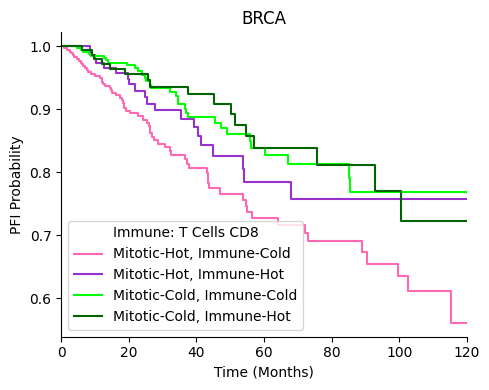

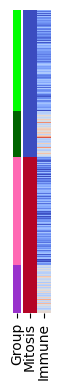

In [61]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans

immune_feat =  "T Cells CD8" # "Lymphocytes" #

# Prepare the data (as per your code snippet)
mosi = pd.concat([df1_common["temperature"], df2_common[[immune_feat, "PFI", "PFI Time"]]], axis=1)
mosi = mosi.dropna(axis=0, how="any")
mosi["temperature"] = mosi["temperature"].apply(lambda x: 1 if x == "Hot" else 0)

# Reformat time events
mosi = mosi.reset_index(drop=True)
mosi["PFI Time"] = mosi["PFI Time"] / 30
# Censor at 10 years
ids = mosi[mosi["PFI Time"] > 120].index
mosi.loc[ids, "PFI Time"] = 120
mosi.loc[ids, "PFI"] = 0

# Standardize the features
mosi[["temperature", immune_feat]] = (mosi[["temperature", immune_feat]] - mosi[["temperature", immune_feat]].min()) / (mosi[["temperature", immune_feat]].max() - mosi[["temperature", immune_feat]].min())

df = mosi.copy()

# Split the DataFrame into two based on mitosis column
df_mitosis_1 = df[df['temperature'] == 1].copy()
df_mitosis_0 = df[df['temperature'] == 0].copy()

# Apply KMeans clustering to each subset based on the immune column
kmeans_1 = KMeans(n_clusters=2, random_state=0).fit(df_mitosis_1[[immune_feat]])
kmeans_0 = KMeans(n_clusters=2, random_state=0).fit(df_mitosis_0[[immune_feat]])

# Add cluster labels to the subsets
df_mitosis_1['immune_cluster'] = kmeans_1.labels_
df_mitosis_0['immune_cluster'] = kmeans_0.labels_

# Function to determine which cluster is "cold" and which is "hot"
def determine_cluster_labels(df, cluster_col, value_col):
    cluster_means = df.groupby(cluster_col)[value_col].mean()
    cold_cluster = cluster_means.idxmin()
    hot_cluster = cluster_means.idxmax()
    return {cold_cluster: 'Immune-Cold', hot_cluster: 'Immune-Hot'}

# Determine cluster labels for mitosis 1 and mitosis 0 subsets
cluster_labels_1 = determine_cluster_labels(df_mitosis_1, 'immune_cluster', immune_feat)
cluster_labels_0 = determine_cluster_labels(df_mitosis_0, 'immune_cluster', immune_feat)

# Apply the cluster labels to the subsets
df_mitosis_1['immune_label'] = df_mitosis_1['immune_cluster'].map(cluster_labels_1)
df_mitosis_0['immune_label'] = df_mitosis_0['immune_cluster'].map(cluster_labels_0)

# Function to label the clusters
def label_cluster(row):
    if row['temperature'] == 1:
        return f'Mitotic-Hot, {row["immune_label"]}'
    else:
        return f'Mitotic-Cold, {row["immune_label"]}'

# Combine the subsets back into a single DataFrame
df_combined = pd.concat([df_mitosis_1, df_mitosis_0], ignore_index=True)

# Apply the labeling function to create the labeled_cluster column
df_combined['labeled_cluster'] = df_combined.apply(label_cluster, axis=1)
mosi = df_combined.sort_values(by='labeled_cluster')

# # Drop the temporary 'immune_cluster' and 'immune_label' columns
# df_combined.drop(columns=['immune_cluster', 'immune_label'], inplace=True)

# # Perform hierarchical clustering
# clustering = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
# mosi['cluster'] = clustering.fit_predict(mosi[["temperature", immune_feat]])

# # row_linkage = linkage(pdist(mosi[["temperature", immune_feat]]), method='ward')
# # mosi['cluster'] = fcluster(row_linkage, 4, criterion='maxclust')

# # First, finding the mitotic-hot clusters
# mit_hot = []
# mit_cold = []
# mit_temp = []
# for cluster in range(4):
#     cluster_data = mosi[mosi['cluster'] == cluster]
#     temp_mean = cluster_data['temperature'].mean()
#     mit_temp.append(temp_mean)
# mit_temp_df = pd.DataFrame({"mit_mean":mit_temp})
# mit_temp_index = mit_temp_df.sort_values(by="mit_mean").index.to_list()
# mit_cold = mit_temp_index[:2]
# mit_hot = mit_temp_index[2:]


# # Now label clusters based on immune and mitosis
# cluster_labels = {}

# immune_means = []
# for cluster in mit_cold:
#     cluster_data = mosi[mosi['cluster'] == cluster]
#     immune_mean = cluster_data[immune_feat].mean()
#     immune_means.append(immune_mean)
# immune_hot_id = np.argmax(immune_means)
# immune_cold_id = np.argmin(immune_means)
# cluster_labels[mit_cold[immune_hot_id]]= "Mitotic-Cold, Immune-Hot"
# cluster_labels[mit_cold[immune_cold_id]]= "Mitotic-Cold, Immune-Cold"

# immune_means = []
# for cluster in mit_hot:
#     cluster_data = mosi[mosi['cluster'] == cluster]
#     immune_mean = cluster_data[immune_feat].mean()
#     immune_means.append(immune_mean)
# immune_hot_id = np.argmax(immune_means)
# immune_cold_id = np.argmin(immune_means)
# cluster_labels[mit_hot[immune_hot_id]]= "Mitotic-Hot, Immune-Hot"
# cluster_labels[mit_hot[immune_cold_id]]= "Mitotic-Hot, Immune-Cold"


# # Determine the labels based on mean values within each cluster
# immune_feat_median = mosi[immune_feat].mean()
# cluster_labels = {}

# for cluster in range(4):
#     cluster_data = mosi[mosi['cluster'] == cluster]
#     temp_mean = cluster_data['temperature'].mean()
#     cd8_mean = cluster_data[immune_feat].mean()
#     print(temp_mean, cd8_mean)
#     if temp_mean < 0.5:  # Mitotic-Cold
#         if cd8_mean < immune_feat_median:
#             cluster_labels[cluster] = "Mitotic-Cold, Immune-Cold"
#         else:
#             cluster_labels[cluster] = "Mitotic-Cold, Immune-Hot"
#     else:  # Mitotic-Hot
#         if cd8_mean < immune_feat_median:
#             cluster_labels[cluster] = "Mitotic-Hot, Immune-Cold"
#         else:
#             cluster_labels[cluster] = "Mitotic-Hot, Immune-Hot"
#     print(cluster_labels[cluster])

# # Map the cluster numbers to labels
# mosi['labeled_cluster'] = mosi['cluster'].map(cluster_labels)

# Create a color palette
# unique_clusters = sorted(mosi['labeled_cluster'].unique())
# palette = sns.color_palette("colorblind", len(unique_clusters))
# cluster_colors = dict(zip(unique_clusters, palette))
cluster_colors = {"Mitotic-Hot, Immune-Cold": "hotpink",
                  "Mitotic-Hot, Immune-Hot": "darkorchid",
                  "Mitotic-Cold, Immune-Cold": "lime",
                  "Mitotic-Cold, Immune-Hot": "darkgreen"}
unique_clusters = list(cluster_colors.keys())

# Plot Kaplan-Meier survival plots
kmf = KaplanMeierFitter()
plt.figure(figsize=(5, 4))

# Store Kaplan-Meier plots to add at risk counts later
for cluster in unique_clusters:
    mask = mosi['labeled_cluster'] == cluster
    kmf.fit(mosi.loc[mask, 'PFI Time'], event_observed=mosi.loc[mask, "PFI"], label=cluster)
    ax = kmf.plot(ci_show=False, color=cluster_colors[cluster])


# Perform pairwise log-rank tests and annotate p-values
p_values = {}
clusters = mosi['labeled_cluster'].unique()
for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]
        mask1 = mosi['labeled_cluster'] == cluster1
        mask2 = mosi['labeled_cluster'] == cluster2
        results = logrank_test(mosi.loc[mask1, 'PFI Time'], mosi.loc[mask2, 'PFI Time'],
                               event_observed_A=mosi.loc[mask1, "PFI"], event_observed_B=mosi.loc[mask2, "PFI"])
        p_values[(cluster1, cluster2)] = results.p_value

for cats, pval in p_values.items():
    print(f"{cats[0]} vs {cats[1]}: p-value={pval:.02}")

plt.xlim([0, 120])
plt.xlabel('Time (Months)')
plt.ylabel('PFI Probability')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Position legend outside and to the right of the plot box
plt.legend(title=f"Immune: {immune_feat}")
# ax.legend().set_visible(False)
ax.set_title(cancer_type)

plt.tight_layout()

# Map each row to a color
row_colors = mosi['labeled_cluster'].map(cluster_colors)
row_colors = row_colors.rename("Group")
mosi = mosi.rename(columns={"temperature":"Mitosis", immune_feat:"Immune"})
# Plot the clustermap
sns.clustermap(mosi[["Mitosis", "Immune"]], standard_scale=None, z_score=None, col_cluster=False, cmap="coolwarm",
               row_cluster=False, method='ward', figsize=(0.7, 4), cbar_pos=None, yticklabels=False, xticklabels=True,
               row_colors=row_colors, dendrogram_ratio=0, colors_ratio=0.2)


In [49]:
mosi['labeled_cluster']

490    Mitotic-Cold, Immune-Cold
230    Mitotic-Cold, Immune-Cold
229    Mitotic-Cold, Immune-Cold
228    Mitotic-Cold, Immune-Cold
227    Mitotic-Cold, Immune-Cold
                 ...            
41       Mitotic-Hot, Immune-Hot
13       Mitotic-Hot, Immune-Hot
17       Mitotic-Hot, Immune-Hot
8        Mitotic-Hot, Immune-Hot
19       Mitotic-Hot, Immune-Hot
Name: labeled_cluster, Length: 491, dtype: object

In [38]:
ALL_CANCERS = ['BRCA', 'KIRC', 'UCEC', 'LGG', 'LUSC', 'LUAD', 'HNSC', 'COADREAD', 'SKCM',
                'GBM', 'BLCA', 'STAD', 'LIHC', 'KIRP', 'CESC', 'PAAD', 'ESCA', 'PCPG', 'KICH', 'OV']

immune_feats = [
    # "IFN-gamma Response", "TGF-beta Response","BCR Evenness","TCR Evenness",
        "Th1 Cells","Th2 Cells","Th17 Cells","B Cells Memory","B Cells Naive",
                "Dendritic Cells Activated","Dendritic Cells Resting","Macrophages M0","Macrophages M1","Macrophages M2",
                "Mast Cells Activated","Mast Cells Resting","Monocytes","NK Cells Activated","NK Cells Resting",
                "Plasma Cells","T Cells CD4 Memory Activated","T Cells CD4 Memory Resting","T Cells CD4 Naive",
                "T Cells CD8","T Cells Follicular Helper","T Cells Regulatory Tregs","Lymphocytes","Neutrophils",
                "Eosinophils","Mast Cells","Dendritic Cells","Macrophages"]

# immune_feats = ["Nonsilent Mutation Rate", "SNV Neoantigens", "Intratumor Heterogeneity", "Aneuploidy Score", "Number of Segments", "Fraction Altered", "Homologous Recombination Defects"]
all_corr = []
all_pval = []
for cancer_type in ALL_CANCERS + ["Mitotic Hot", "Mitotic Cold", "All"]:

    if cancer_type in ["Mitotic Hot", "Mitotic Cold", "All"]:
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"].isin(ALL_CANCERS)]
        gene_exp_cancer = immune_df[immune_df["TCGA Study"].isin(ALL_CANCERS)]
    else:
        mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
        gene_exp_cancer = immune_df[immune_df["TCGA Study"]==cancer_type]

    if cancer_type=="Mitotic Hot":
        mitosis_feats_cancer = mitosis_feats_cancer[mitosis_feats_cancer["temperature"]=="Hot"]
    if cancer_type=="Mitotic Cold":
        mitosis_feats_cancer = mitosis_feats_cancer[mitosis_feats_cancer["temperature"]=="Cold"]

    # drop missing mutations
    gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")
    # drop cases with all mutations as Nan


    # Find the common case names between mitosis features and gene expressions
    common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['TCGA Participant Barcode']))))
    ## Keep only the rows with the common case names in both dataframes
    df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
    df2_common = gene_exp_cancer[gene_exp_cancer['TCGA Participant Barcode'].isin(common_cases)]
    df2_common = df2_common.drop_duplicates(subset='TCGA Participant Barcode')

    ## Sort the dataframes based on 'case_name'
    df1_common = df1_common.sort_values('bcr_patient_barcode')
    df2_common = df2_common.sort_values('TCGA Participant Barcode')

    df1_common = df1_common.reset_index(drop=True)
    df2_common = df2_common.reset_index(drop=True)

    X = df1_common[["mean(ND)"]]
    Y = df2_common[immune_feats]
    corr_matrix, pvalue_matrix = calculate_corr_matrix(Y, X, method='spearman', pvalue_correction="bonferroni")

    all_corr.append(corr_matrix.rename(columns={"mean(ND)": cancer_type}))
    all_pval.append(pvalue_matrix.rename(columns={"mean(ND)": cancer_type}))

corr_matrix = pd.concat(all_corr, axis=1)
pvalue_matrix = pd.concat(all_pval, axis=1)

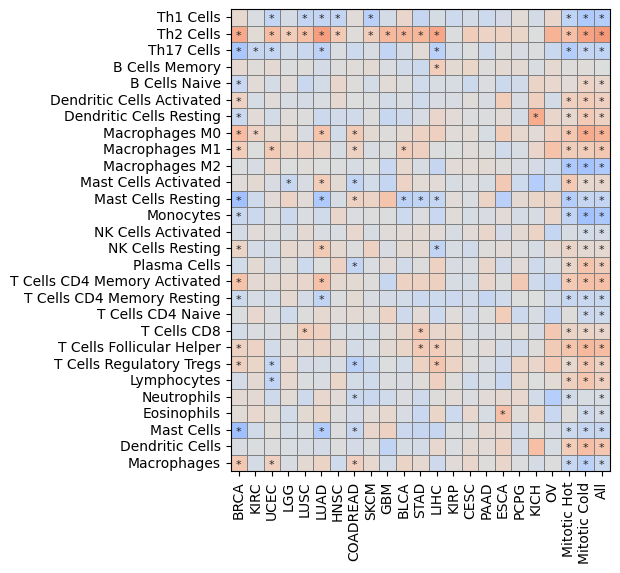

In [39]:
# Plot the heatmap with reordered data and customization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '') #  
heatmap = sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                    linewidths=0.5, linecolor='gray', square=True,
                    annot=annotations, fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                    cbar_kws={'shrink': 0.5, 'label': 'Pearson r'}, yticklabels=True, xticklabels=True,
                    ax=ax)


for _, spine in heatmap.spines.items():
    spine.set_visible(True)

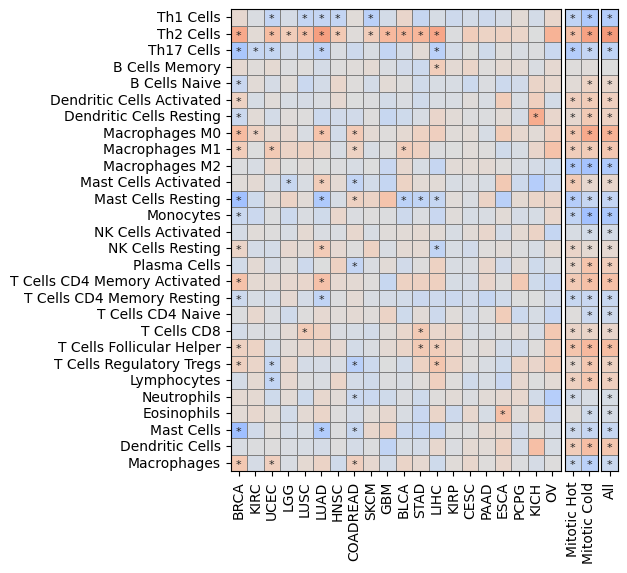

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 6), gridspec_kw={'width_ratios': [corr_matrix.shape[1]-3, 2, 1]})
annotations = pvalue_matrix.applymap(lambda x: '*' if x < 0.05 else '') 
# Plot the heatmap for all but the last column
heatmap1 = sns.heatmap(corr_matrix.iloc[:, :-3], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, :-3], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=True, xticklabels=True, ax=ax1)

heatmap2 = sns.heatmap(corr_matrix.iloc[:, -3:-1], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, -3:-1], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=False, xticklabels=True, ax=ax2)

# Plot the heatmap for the last column
heatmap3 = sns.heatmap(corr_matrix.iloc[:, -1:], cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                       linewidths=0.5, linecolor='gray', square=True,
                       annot=annotations.iloc[:, -1:], fmt='', annot_kws={"size": 8, "va": "center_baseline", "ha": "center"},
                       yticklabels=False, xticklabels=True, ax=ax3)

for _, spine in heatmap1.spines.items():
    spine.set_visible(True)

for _, spine in heatmap2.spines.items():
    spine.set_visible(True)

for _, spine in heatmap3.spines.items():
    spine.set_visible(True)

for label in heatmap2.get_xticklabels():
    label.set_rotation(90)

for label in heatmap3.get_xticklabels():
    label.set_rotation(90)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.show()
